# Hotel Booking Classification

## Libraries

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Metrics
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Load Data

In [2]:
# Load the dataset
df = pd.read_csv('data/hotel_booking_features.csv')
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,continent_EU,continent_NA,continent_OC,continent_SA,continent_Unknown,country_ESP,country_FRA,country_GBR,country_Other,country_PRT
0,0,342,2015,27,1,0,0,2,0.0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,737,2015,27,1,0,0,2,0.0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,7,2015,27,1,0,1,1,0.0,0,...,1,0,0,0,0,0,0,1,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,1,0,0,0,0,0,0,1,0,0


In [3]:
df.shape

(119390, 55)

## Train / Test

In [14]:
sampled_df = df.sample(frac=0.1, random_state=42)

X = sampled_df.drop('is_canceled', axis=1)
y = sampled_df['is_canceled']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

## Cross-validation

In [15]:
sampled_df['is_canceled'].value_counts()

is_canceled
0    7428
1    4511
Name: count, dtype: int64

In [23]:
# Declare KFold
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Declare scores to be used
scoring = {
    'Bacc': make_scorer(balanced_accuracy_score),
    'Prec': make_scorer(precision_score),
    'Rec': make_scorer(recall_score)
}

In [17]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(2))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(2))
        
def print_metrics_rs(rand_search, idx=None):
    if idx is None:
        idx = rand_search.best_index_
    for sc in scoring.keys():
        print(f'Train {sc}:', rand_search.cv_results_[f'mean_train_{sc}'][idx].round(2))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', rand_search.cv_results_[f'mean_test_{sc}'][idx].round(2))

## Models

### Baseline 1

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
bl1 = DummyClassifier(strategy='most_frequent')
bl1_cv = cross_validate(bl1, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(bl1_cv)

Train Bacc: 0.5
Train Prec: 0.0
Train Rec: 0.0

Validation Bacc: 0.5
Validation Prec: 0.0
Validation Rec: 0.0


/home/ibci/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibci/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibci/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ibci/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWar

### Baseline 2

In [24]:
bl2 = LogisticRegression(max_iter=10_000)
bl2_cv = cross_validate(bl2, X_train[['previous_cancellations']], y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(bl2_cv)

Train Bacc: 0.57
Train Prec: 0.93
Train Rec: 0.14

Validation Bacc: 0.57
Validation Prec: 0.93
Validation Rec: 0.14


In [25]:
bl2 = LogisticRegression(max_iter=10_000)
bl2_cv = cross_validate(bl2, X_train[['lead_time']], y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(bl2_cv)

Train Bacc: 0.59
Train Prec: 0.6
Train Rec: 0.3

Validation Bacc: 0.59
Validation Prec: 0.6
Validation Rec: 0.3


### Logistic Regression

In [26]:
lr = Pipeline([
    ('scaler', RobustScaler()),
    ('lr', LogisticRegression(solver='saga', max_iter=10_000, n_jobs=-1))
])

lr_cv = cross_validate(lr, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(lr_cv)

Train Bacc: 0.8
Train Prec: 0.82
Train Rec: 0.68

Validation Bacc: 0.79
Validation Prec: 0.81
Validation Rec: 0.68


### Decision Tree

In [27]:
from sklearn.tree import plot_tree

In [28]:
dt = DecisionTreeClassifier(max_depth=20)
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.97
Train Prec: 0.98
Train Rec: 0.96

Validation Bacc: 0.8
Validation Prec: 0.74
Validation Rec: 0.75


Train Bacc: 0.75
Train Prec: 0.74
Train Rec: 0.64

Validation Bacc: 0.75
Validation Prec: 0.74
Validation Rec: 0.64


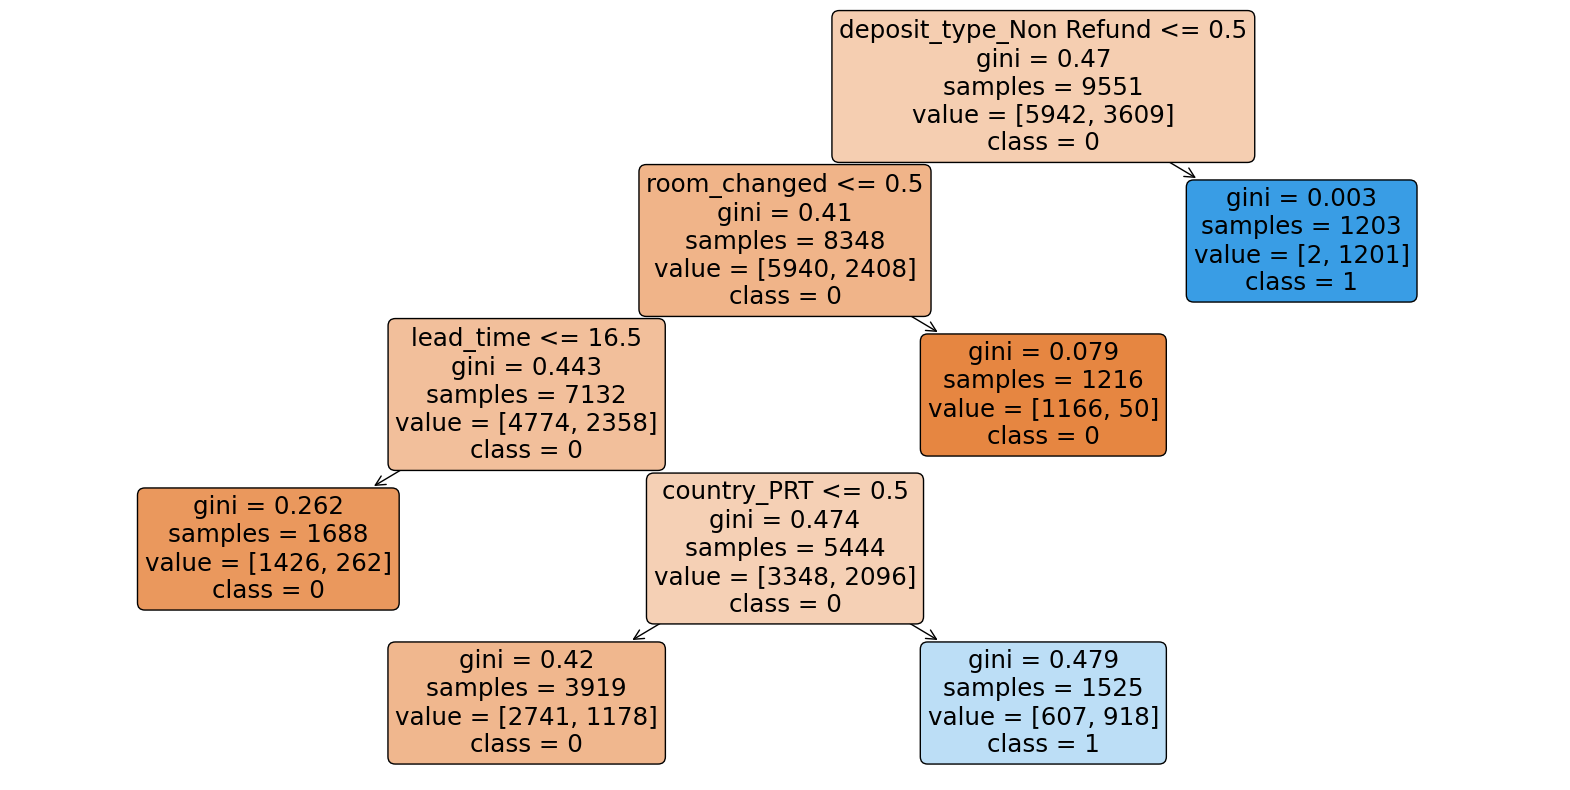

In [29]:
dt = DecisionTreeClassifier(max_depth=4,
                            min_samples_leaf=100,
                            min_impurity_decrease=0.01,
                            random_state=42)
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)
print_metrics(dt_cv)
dt.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=list(X.columns),
          class_names=['0', '1'], rounded=True)
plt.show()

### Random Forest

In [30]:
rf = RandomForestClassifier(max_depth=20)
rf_cv = cross_validate(rf, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 0.98
Train Prec: 0.98
Train Rec: 0.97

Validation Bacc: 0.84
Validation Prec: 0.86
Validation Rec: 0.75


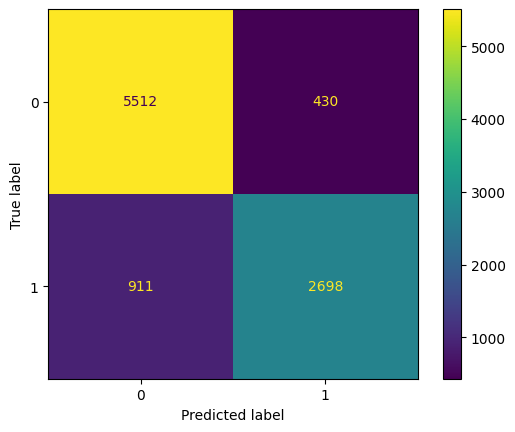

In [31]:
# cross_val_predict returns the predictions for each data point in the validation sets
val_preds = cross_val_predict(rf, X_train, y_train, cv=kf)

cm = confusion_matrix(y_train, val_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

In [32]:
rf.fit(X_train, y_train)
rf_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

rf_ft_imps.head(20)

,feature,importance
29,deposit_type_Non Refund,0.115
0,lead_time,0.113
53,country_PRT,0.091
17,total_of_special_requests,0.067
15,adr,0.067
2,arrival_date_week_number,0.050
3,arrival_date_day_of_month,0.046
20,room_changed,0.043
27,market_segment_Online TA,0.035
5,stays_in_week_nights,0.034


## Balance

### DT experiments

In [140]:
# Class weight

dt = DecisionTreeClassifier(max_depth=20, class_weight='balanced')
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.98
Train Prec: 0.96
Train Rec: 0.99

Validation Bacc: 0.8
Validation Prec: 0.73
Validation Rec: 0.77


In [137]:
# Random Undersampling

dt_pipe = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('dt', DecisionTreeClassifier(max_depth=20)),
])
dt_cv = cross_validate(dt_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.95
Train Prec: 0.87
Train Rec: 0.98

Validation Bacc: 0.79
Validation Prec: 0.7
Validation Rec: 0.8


In [138]:
# Random Oversampling

dt_pipe = ImbPipeline([
    ('ros', RandomOverSampler()),
    ('dt', DecisionTreeClassifier(max_depth=20)),
])
dt_cv = cross_validate(dt_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.98
Train Prec: 0.96
Train Rec: 0.98

Validation Bacc: 0.8
Validation Prec: 0.74
Validation Rec: 0.76


In [139]:
# SMOTE

dt_pipe = ImbPipeline([
    ('smote', SMOTE()),
    ('dt', DecisionTreeClassifier(max_depth=20)),
])
dt_cv = cross_validate(dt_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.97
Train Prec: 0.96
Train Rec: 0.97

Validation Bacc: 0.79
Validation Prec: 0.72
Validation Rec: 0.75


### RF class weight

In [33]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = [{
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, 50, None],
    'class_weight': [
        'balanced',
        {0: 1, 1: 1},
        {0: 1, 1: 2},
        {0: 1, 1: 3},
    ]
}]

rf_rs = RandomizedSearchCV(rf,
                           n_iter=10,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

rf_rs.fit(X_train, y_train)

print(rf_rs.best_params_)
print()
print_metrics_rs(rf_rs)

{'n_estimators': 100, 'max_depth': 20, 'class_weight': {0: 1, 1: 3}}

Train Bacc: 0.98
Train Prec: 0.94
Train Rec: 1.0

Validation Bacc: 0.84
Validation Prec: 0.8
Validation Rec: 0.81


### GB class weight

In [34]:
from lightgbm import LGBMClassifier

/home/ibci/.local/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 9.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [35]:
lb_gbdt = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,
                         class_weight='balanced', num_leaves=10, verbose=0, n_jobs=-1)
gb_cv = cross_validate(lb_gbdt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Train Bacc: 0.9
Train Prec: 0.84
Train Rec: 0.9

Validation Bacc: 0.84
Validation Prec: 0.77
Validation Rec: 0.83


### SVC

In [147]:
svc_pipe = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('svc', SVC()),
])

svc_cv = cross_validate(svc_pipe, X_train, y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(svc_cv)

Train Bacc: 0.61
Train Prec: 0.54
Train Rec: 0.46

Validation Bacc: 0.61
Validation Prec: 0.54
Validation Rec: 0.46


### Balanced RF

In [36]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [37]:
brf = BalancedRandomForestClassifier(200,
                                     max_depth=None,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     n_jobs=-1)
brf_cv = cross_validate(brf, X_train, y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(brf_cv)

Train Bacc: 0.98
Train Prec: 0.94
Train Rec: 1.0

Validation Bacc: 0.85
Validation Prec: 0.76
Validation Rec: 0.86


In [38]:
brf.fit(X_train, y_train)
brf_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': brf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

brf_ft_imps.head(20)

,feature,importance
0,lead_time,0.124
29,deposit_type_Non Refund,0.089
15,adr,0.078
53,country_PRT,0.075
2,arrival_date_week_number,0.063
17,total_of_special_requests,0.058
3,arrival_date_day_of_month,0.058
20,room_changed,0.040
5,stays_in_week_nights,0.038
27,market_segment_Online TA,0.032


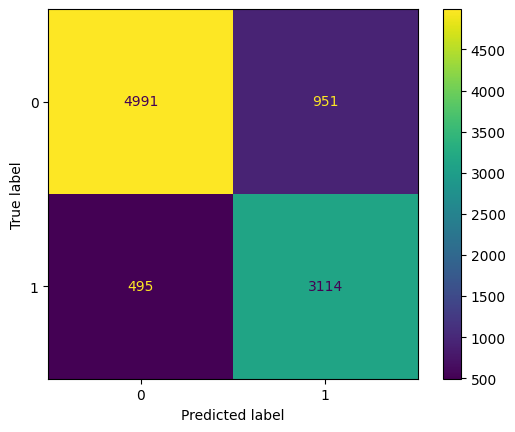

In [39]:
# cross_val_predict returns the predictions for each data point in the validation sets
val_preds = cross_val_predict(brf, X_train, y_train, cv=kf)

cm = confusion_matrix(y_train, val_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

#### Randomized search

In [40]:
brf = BalancedRandomForestClassifier(sampling_strategy='not minority',
                                     replacement=True,
                                     random_state=42,
                                     n_jobs=-1)

params = [{
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [5, 10, 30, 50, None],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'max_leaf_nodes': [None, 5, 10, 20],
}]

brf_rs = RandomizedSearchCV(brf,
                           n_iter=20,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

brf_rs.fit(X_train, y_train)

print(brf_rs.best_params_)
print()
print_metrics_rs(brf_rs)

{'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_leaf_nodes': None, 'max_depth': 30}

Train Bacc: 0.89
Train Prec: 0.83
Train Rec: 0.89

Validation Bacc: 0.84
Validation Prec: 0.78
Validation Rec: 0.83


In [42]:
# Round 2

brf = BalancedRandomForestClassifier(max_samples=0.5,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     random_state=42,
                                     n_jobs=-1)

params = [{
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 20, 30, 40, 50, None],
}]

brf_rs = GridSearchCV(brf,
                      param_grid=params,
                      scoring=scoring,
                      cv=kf,
                      refit='Bacc',
                      return_train_score=True,
                      n_jobs=-1)

brf_rs.fit(X_train, y_train)

print(brf_rs.best_params_)
print()
print_metrics_rs(brf_rs)

{'max_depth': 20, 'n_estimators': 500}

Train Bacc: 0.96
Train Prec: 0.9
Train Rec: 0.99

Validation Bacc: 0.85
Validation Prec: 0.78
Validation Rec: 0.85


In [43]:
brf_rs.cv_results_['mean_test_Bacc']

array([0.83942321, 0.83868633, 0.83854778, 0.84979528, 0.85177992,
       0.85135926, 0.84867596, 0.84927022, 0.85155663, 0.85004173,
       0.85041332, 0.85050257, 0.85004173, 0.85027478, 0.85041844,
       0.85004173, 0.85027478, 0.85041844])

In [44]:
brf_rs.cv_results_['mean_test_Rec']

array([0.81213633, 0.80881131, 0.80853422, 0.84954281, 0.85065115,
       0.85065115, 0.85369909, 0.85286783, 0.85508451, 0.85508451,
       0.85397617, 0.85314492, 0.85508451, 0.85369909, 0.85314492,
       0.85508451, 0.85369909, 0.85314492])

In [45]:
brf_rs.cv_results_['mean_test_Prec']

array([0.78730619, 0.78894033, 0.78889131, 0.77504129, 0.77863502,
       0.7775992 , 0.76856649, 0.77066377, 0.77383448, 0.77036562,
       0.77225868, 0.77324056, 0.77036562, 0.77220335, 0.77303877,
       0.77036562, 0.77220335, 0.77303877])

#### Full train

In [46]:
X_full = df.drop('is_canceled', axis=1)
y_full = df['is_canceled']

# Train / Test split
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, stratify=y_full,
                                                                        test_size=0.2, random_state=42)

In [47]:
brf = BalancedRandomForestClassifier(500,
                                     max_depth=20,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     n_jobs=-1)
brf_cv = cross_validate(brf, X_full_train, y_full_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(brf_cv)

Train Bacc: 0.93
Train Prec: 0.85
Train Rec: 0.95

Validation Bacc: 0.87
Validation Prec: 0.8
Validation Rec: 0.87


In [48]:
brf.fit(X_full_train, y_full_train)
# get the probabilities for the positive class in the validation sets
y_val_probs = cross_val_predict(brf, X_full_train, y_full_train, cv=kf, method='predict_proba')
y_val_probs_1 = y_val_probs[:, 1]

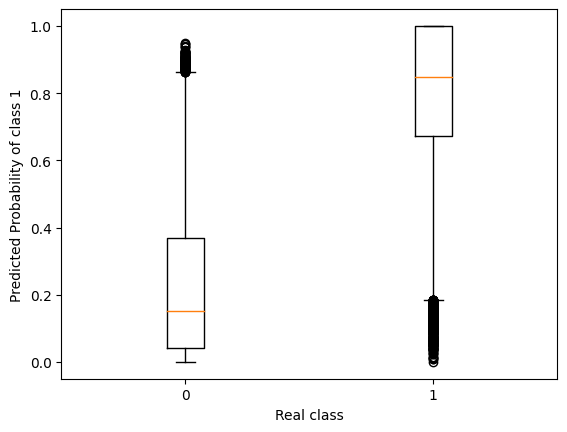

In [60]:
idx0 = np.where(y_full_train == 0)[0]
idx1 = np.where(y_full_train == 1)[0]

plt.boxplot([y_val_probs_1[idx0], y_val_probs_1[idx1]], labels=[0, 1])
plt.xlabel('Real class')
plt.ylabel('Predicted Probability of class 1')
plt.show()

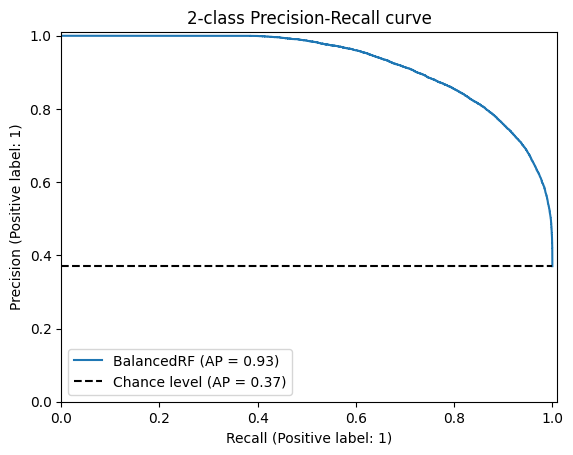

In [61]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    y_full_train, y_val_probs_1, name="BalancedRF", plot_chance_level=True
)
display.ax_.set_xlim((0, 1.01))
display.ax_.set_ylim((0, 1.01))
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [62]:
(y_val_probs_1 > 0.1).astype(int)

array([1, 1, 1, ..., 1, 1, 0])

In [64]:
print('Threshold | Precision | Recall')
for th in list(np.arange(0, 1, 0.1)) + [0.9999]:
    rec = recall_score(y_full_train, y_val_probs_1 > th)
    prec = precision_score(y_full_train, y_val_probs_1 > th)
    print(f'{round(th, 1)} | {round(prec, 2)} | {round(rec, 2)}')

0.0 1.0 0.37
0.1 1.0 0.5
0.2 0.99 0.57
0.3 0.97 0.63
0.4 0.93 0.71
0.5 0.87 0.8
0.6 0.8 0.85
0.7 0.73 0.9
0.8 0.59 0.96
0.9 0.43 1.0
1.0 0.15 1.0


## Log features dataset

In [65]:
df2 = pd.read_csv('data/hotel_booking_log_features.csv')

In [66]:
X2 = df2.drop('is_canceled', axis=1)
y2 = df2['is_canceled']

# Train / Test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, stratify=y2,
                                                        test_size=0.2, random_state=42)

In [67]:
brf = BalancedRandomForestClassifier(500,
                                     max_depth=20,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     n_jobs=-1)
brf_cv = cross_validate(brf, X2_train, y2_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(brf_cv)

Train Bacc: 0.93
Train Prec: 0.85
Train Rec: 0.96

Validation Bacc: 0.87
Validation Prec: 0.79
Validation Rec: 0.87


No difference with previous data!

In [73]:
brf.fit(X2_train, y2_train)
brf_ft_imps = pd.DataFrame({
    'feature': X2_train.columns,
    'importance': brf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

brf_ft_imps.head(20)

,feature,importance
18,deposit_type_Non Refund,0.122
28,lead_time_log,0.121
27,country_PRT,0.101
38,total_of_special_requests_log,0.069
36,adr_log,0.057
9,room_changed,0.056
16,market_segment_Online TA,0.042
1,arrival_date_week_number,0.042
37,required_car_parking_spaces_log,0.039
2,arrival_date_day_of_month,0.035


## DateTime features dataset

In [68]:
df3 = pd.read_csv('data/hotel_booking_dt_features.csv')

In [69]:
X3 = df3.drop('is_canceled', axis=1)
y3 = df3['is_canceled']

# Train / Test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify=y3,
                                                        test_size=0.2, random_state=42)

In [74]:
from sklearn.model_selection import TimeSeriesSplit

ts_kf = TimeSeriesSplit(n_splits=5)

### DT

In [85]:
dt = ImbPipeline([
    ('RUS', RandomUnderSampler()),
    ('dt', DecisionTreeClassifier(max_depth=20))
])
dt_cv = cross_validate(dt, X3_train, y3_train, cv=ts_kf,
                       scoring=scoring, return_train_score=True)

print_metrics(dt_cv)

Train Bacc: 0.93
Train Prec: 0.85
Train Rec: 0.97

Validation Bacc: 0.84
Validation Prec: 0.75
Validation Rec: 0.85


Train Bacc: 0.75
Train Prec: 0.71
Train Rec: 0.66

Validation Bacc: 0.75
Validation Prec: 0.71
Validation Rec: 0.66


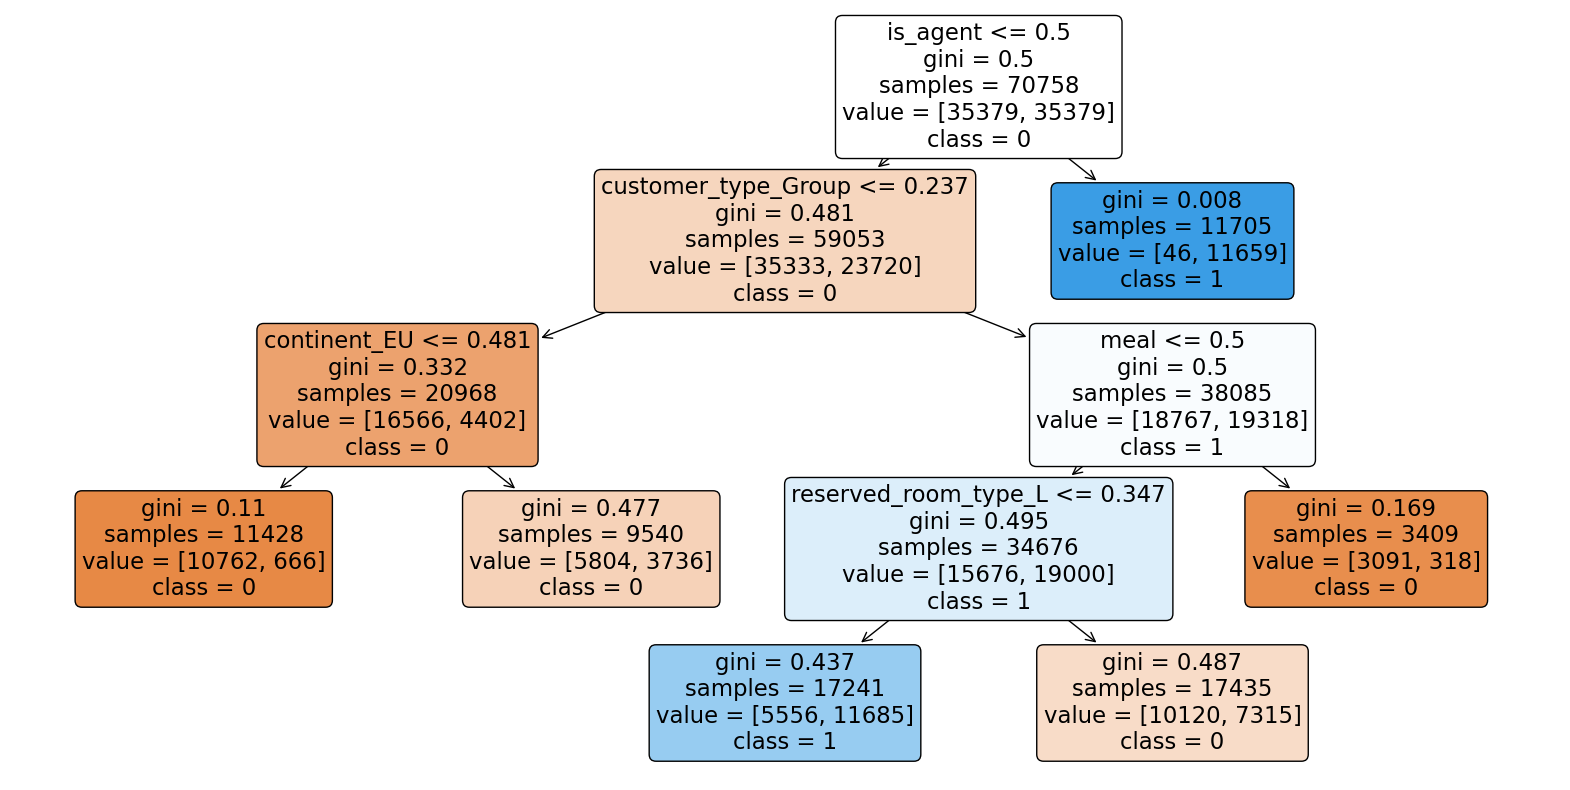

In [87]:
dt_raw = DecisionTreeClassifier(max_depth=4,
                                min_samples_leaf=100,
                                min_impurity_decrease=0.01,
                                random_state=42)
dt = ImbPipeline([
    ('RUS', RandomUnderSampler()),
    ('dt', dt_raw)
])
dt_cv = cross_validate(dt, X3_train, y3_train, cv=kf,
                       scoring=scoring, return_train_score=True)
print_metrics(dt_cv)
dt.fit(X3_train, y3_train)

plt.figure(figsize=(20,10))
plot_tree(dt_raw, filled=True, feature_names=list(X.columns),
          class_names=['0', '1'], rounded=True)
plt.show()

### BRF

In [75]:
brf = BalancedRandomForestClassifier(500,
                                     max_depth=20,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     n_jobs=-1)
brf_cv = cross_validate(brf, X3_train, y3_train, cv=ts_kf,
                        scoring=scoring, return_train_score=True)

print_metrics(brf_cv)

/home/ibci/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Train Bacc: 0.96
Train Prec: 0.88
Train Rec: 0.99

Validation Bacc: 0.88
Validation Prec: 0.8
Validation Rec: 0.9


In [77]:
brf_cv

{'fit_time': array([ 5.35106301,  6.67386317, 13.04647994, 16.14037991, 20.41419005]),
 'score_time': array([0.31964278, 0.41116214, 0.37516689, 0.370121  , 0.37126255]),
 'test_Bacc': array([0.8789967 , 0.87755593, 0.88305682, 0.8859243 , 0.89132977]),
 'train_Bacc': array([0.96454073, 0.95904642, 0.95513226, 0.95126028, 0.94758215]),
 'test_Prec': array([0.78419545, 0.79116223, 0.80457317, 0.80982445, 0.81000747]),
 'train_Prec': array([0.89523952, 0.88290187, 0.87743942, 0.87140877, 0.86692027]),
 'test_Rec': array([0.89918727, 0.89230244, 0.89412163, 0.89484431, 0.91035756]),
 'train_Rec': array([0.99983333, 0.99567173, 0.9913842 , 0.98806541, 0.98371967])}

In [78]:
brf.fit(X3_train, y3_train)
brf_ft_imps = pd.DataFrame({
    'feature': X3_train.columns,
    'importance': brf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

brf_ft_imps.head(20)

,feature,importance
44,country_pct_cancellations,0.106
40,agent_pct_cancellations,0.097
28,lead_time_log,0.092
18,deposit_type_Non Refund,0.089
39,agent_bookings,0.081
38,total_of_special_requests_log,0.056
43,country_bookings,0.051
27,country_PRT,0.050
9,room_changed,0.041
37,required_car_parking_spaces_log,0.034


## Test

In [89]:
brf = BalancedRandomForestClassifier(500,
                                     max_depth=20,
                                     sampling_strategy='not minority',
                                     replacement=True,
                                     n_jobs=-1)
brf.fit(X3_train, y3_train)

BalancedRandomForestClassifier(max_depth=20, n_estimators=500, n_jobs=-1,
                               replacement=True,
                               sampling_strategy='not minority')

In [99]:
y_pred_test = brf.predict(X3_test)
balanced_accuracy_score(y3_test, y_pred_test).round(2)

0.89

In [101]:
# get the probabilities for the positive class in the test set
y3_test_probs_1 = brf.predict_proba(X3_test)[:, 1]
y3_test_probs_1

array([0.01221376, 0.39585897, 0.91464649, ..., 0.07700964, 0.13306956,
       0.21145607])

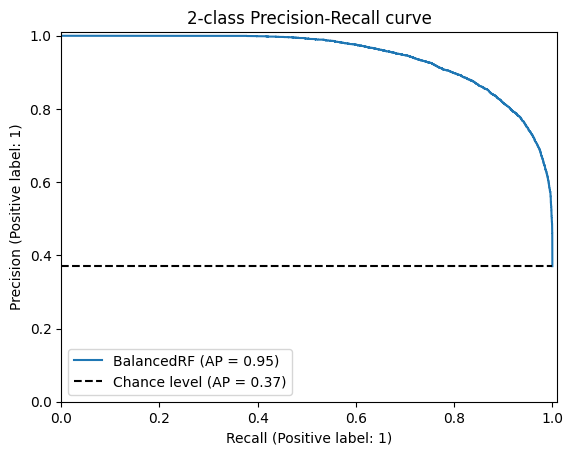

In [104]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    y3_test, y3_test_probs_1, name="BalancedRF", plot_chance_level=True
)
display.ax_.set_xlim((0, 1.01))
display.ax_.set_ylim((0, 1.01))
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [105]:
brf_ft_imps = pd.DataFrame({
    'feature': X3_train.columns,
    'importance': brf.feature_importances_
}).sort_values('importance', ascending=False).round(3)

brf_ft_imps.head(20)

,feature,importance
44,country_pct_cancellations,0.106
40,agent_pct_cancellations,0.101
28,lead_time_log,0.091
18,deposit_type_Non Refund,0.080
39,agent_bookings,0.078
38,total_of_special_requests_log,0.056
27,country_PRT,0.052
43,country_bookings,0.052
9,room_changed,0.043
37,required_car_parking_spaces_log,0.034


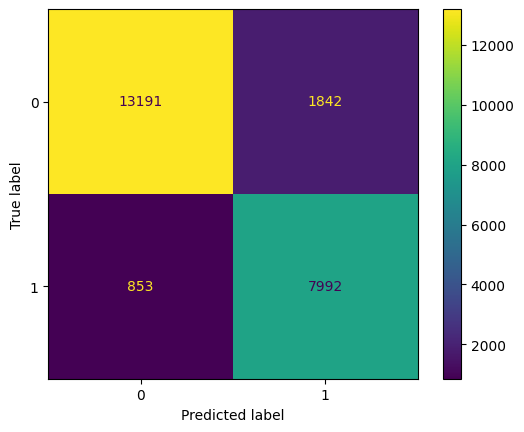

In [106]:
test3_preds = (y3_test_probs_1 > 0.5).astype(int)

cm = confusion_matrix(y3_test, test3_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

What test metrics would we have if we just predicted highly likely probabilities? 

In [145]:
# Percentages study
print(f'Total test samples: {len(y3_test):,}\n')

for limit in [0.1, 0.2, 0.3, 0.4]:
    # indices of the probabilities below limit and above 1-limit
    extreme_prob_idxs = np.where((y3_test_probs_1 < limit) | (y3_test_probs_1 > (1 - limit)))[0]
    preds = (y3_test_probs_1[extreme_prob_idxs] > 0.5).astype(int)

    print(f'{limit} | {1-limit} | Samples: {len(preds):,} ({len(preds)/len(y3_test):.0%})')
    print('-------------')
    print('Bacc:', balanced_accuracy_score(y3_test.iloc[extreme_prob_idxs], preds).round(2))
    print('Prec:', precision_score(y3_test.iloc[extreme_prob_idxs], preds).round(2))
    print('Rec:', recall_score(y3_test.iloc[extreme_prob_idxs], preds).round(2))
    print()

Total test samples: 23,878

0.1 | 0.9 | Samples: 12,237 (51%)
-------------
Bacc: 0.99
Prec: 0.99
Rec: 0.99

0.2 | 0.8 | Samples: 16,283 (68%)
-------------
Bacc: 0.98
Prec: 0.95
Rec: 0.98

0.3 | 0.7 | Samples: 19,137 (80%)
-------------
Bacc: 0.95
Prec: 0.91
Rec: 0.97

0.4 | 0.6 | Samples: 21,519 (90%)
-------------
Bacc: 0.93
Prec: 0.86
Rec: 0.94

